# Network Intrusion Detection

In [17]:
# Imports

import numpy as np
import psutil
import pyshark
import tarfile
from collections import Counter
import nest_asyncio
nest_asyncio.apply()
from scipy.sparse import csr_matrix, save_npz, load_npz, hstack
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## 0 Current RAM usage monitoring

In [2]:
class RamUsage:
    def __init__(self):
        self.memory_info: float
        
    def __call__(self):
        """
        Return Occupied RAM in GiB
        """
        self.memory_info = psutil.Process().memory_info().rss / (1024 * 1024 * 1024)
        return self.memory_info

    def __str__(self):
        _ = self.__call__()
        return f"Current RAM usage: {self.memory_info:.2f} / 24 GB ({self.memory_info/24*100:.1f} %)"
ram = RamUsage()
print(ram)

Current RAM usage: 0.15 / 24 GB (0.6 %)


## 1. Data loading and feature extraction

### Class definition

In [75]:
class TorFiles:
    def __init__(self, file_directory_train: str, file_directory_test: str = None):
        self.file_directory_train = file_directory_train
        self.file_directory_test = file_directory_test
        self.filenames_train: list = [self.file_directory_train]
        self.filenames_test: list = [self.file_directory_test] if self.file_directory_test else None
        
        self.single_cap_features: dict = None
        self.final_features_train: np.ndarray
        self.final_features_test: np.ndarray
        self.packet_names: list = []
        self.packet_names_test: list = []
        self.vectorizers: dict = dict()
        self.scaler: StandardScaler
        self.pca: PCA

    def __str__(self):
        # return f"Number of training example: {len(list(self.single_cap_features.keys()))}\nNumber of test example: {self.nb_file_test}\n{ram.__str__()}"
        return f"Number of training example: {len(self.final_features_train)}\nNumber of test example: {0}\n{ram.__str__()}"

    def init_cap_features(self, single=True, train=True):
        """
        Initialize the features dictionary 'self.single_cap_features' if single=True, 'self.all_cap_features(train/test)' if single=False
        """
        keys = self.add_packet_features('').keys()
        values_single = [[] for i in range(len(keys))]
        values_all = [Counter({}) for i in range(len(keys))]
        if train:
            if single:
                self.single_cap_features = dict(zip(keys, values_single))
            else:
                assert single, "Attempt to initialize self.all_cap_features_train but useless"
                # self.all_cap_features_train = dict(zip(keys, values_all))
        else:
            if single:
                self.single_cap_features = dict(zip(keys, values_single))
            else:
                assert single, "Attempt to initialize self.all_cap_features_train but useless"
                # self.all_cap_features_test = dict(zip(keys, values_all))
        
    def add_packet_features(self, packet, previous_timestamp=None, is_new=True):
        """
        For a given packet, append the extracted features (1 word/int per feature) to the lists in the dict 'single_packet_features'
        """
        single_packet_features = {
            'src_ip': packet.ip.src if 'IP' in packet else '', # BoW (with the whole string, default option)
            'dst_ip': packet.ip.dst if 'IP' in packet else '', # BoW
            'src_port': packet.tcp.srcport if 'TCP' in packet else (packet.udp.srcport if 'UDP' in packet else ''), # BoW
            'dst_port': packet.tcp.dstport if 'TCP' in packet else (packet.udp.dstport if 'UDP' in packet else ''), # BoW
            'transport_protocol': packet.transport_layer if 'IP' in packet else '', # BoW
            'application_protocol': packet.highest_layer if 'IP' in packet else '', # BoW
                'packet_length': int(packet.length) if hasattr(packet, 'length') else -1, # Mean + distribution entropy
                'payload_length': len(packet) if hasattr(packet, 'data') else 0, # Mean + distribution entropy
            'tcp_flags': packet.tcp.flags if 'TCP' in packet else '', # BoW
            'ip_options': 'True' if 'IP' in packet and hasattr(packet.ip, 'options') else 'False', #None if not  else None), # BoW
            'dns_query': packet.dns.qry_name if 'DNS' in packet else '', # BoW
            'dns_response': packet.dns.resp_name if 'DNS' in packet else '', # BoW
            'http_method': packet.http.request_method if 'HTTP' in packet else '', # BoW
            'http_status_code': packet.http.response_code if 'HTTP' in packet else '', # BoW
            'http_user_agent': packet.http.user_agent if 'HTTP' in packet else '', # BoW with 'word' and n=3?n=10?
            'http_host': packet.http.host if 'HTTP' in packet else '', # BoW
            'tls_handshake': packet.tls.handshake if 'TLS' in packet and hasattr(packet.tls, 'handshake') else '', # BoW
            'tls_certificates': packet.tls.certificates if 'TLS' in packet and hasattr(packet.tls, 'certificates') else '', # BoW
                'inter_arrival_time': float(packet.sniff_timestamp) - float(previous_timestamp) if previous_timestamp else 0., # Mean + distribution entropy
            # Mistral's new features
            'window_size': packet.tcp.window_size if 'TCP' in packet and hasattr(packet.tcp, 'window_size') else '',
                'rtt': float(packet.tcp.analysis_ack_rtt) if 'TCP' in packet and hasattr(packet.tcp, 'analysis_ack_rtt') else -1,
            'jitter': packet.tcp.analysis_ack_rtt_var if 'TCP' in packet and hasattr(packet.tcp, 'analysis_ack_rtt_var') else '',
            'packet_loss': 'True' if 'TCP' in packet and hasattr(packet.tcp, 'analysis_lost_segment') else 'False',
            'retransmission': 'True' if 'TCP' in packet and hasattr(packet.tcp, 'analysis_retransmission') else 'False',
            'syn_ack_flags': packet.tcp.flags_syn if 'TCP' in packet and hasattr(packet.tcp, 'flags_syn') else '',
            'icmp_type': packet.icmp.type if 'ICMP' in packet and hasattr(packet.icmp, 'type') else '',
            'icmp_code': packet.icmp.code if 'ICMP' in packet and hasattr(packet.icmp, 'code') else '',
            'dns_query_type': packet.dns.qry_type if 'DNS' in packet and hasattr(packet.dns, 'qry_type') else '',
            'dns_response_code': packet.dns.resp_code if 'DNS' in packet and hasattr(packet.dns, 'resp_code') else '',
            'http_content_type': packet.http.content_type if 'HTTP' in packet and hasattr(packet.http, 'content_type') else '',
                'http_content_length': int(packet.http.content_length) if 'HTTP' in packet and hasattr(packet.http, 'content_length') else -1,
            'tls_version': packet.tls.version if 'TLS' in packet and hasattr(packet.tls, 'version') else '',
            'tls_cipher_suite': packet.tls.cipher_suite if 'TLS' in packet and hasattr(packet.tls, 'cipher_suite') else '',
            'ip_ttl': packet.ip.ttl if 'IP' in packet and hasattr(packet.ip, 'ttl') else '',
            'ip_fragmentation': packet.ip.frag_offset if 'IP' in packet and hasattr(packet.ip, 'frag_offset') else '',
                'tcp_sequence_number': int(packet.tcp.seq) if 'TCP' in packet and hasattr(packet.tcp, 'seq') else -1,
                'tcp_acknowledgment_number': int(packet.tcp.ack) if 'TCP' in packet and hasattr(packet.tcp, 'ack') else -1,
            'udp_checksum': packet.udp.checksum if 'UDP' in packet and hasattr(packet.udp, 'checksum') else '',
            'icmp_checksum': packet.icmp.checksum if 'ICMP' in packet and hasattr(packet.icmp, 'checksum') else '',
        }
        if self.single_cap_features:
            for key in self.single_cap_features.keys():
                # Let int type or convert to str
                tostring = True
                if key in ['packet_length', 'payload_length', 'inter_arrival_time', 'rtt', 'http_content_length', 'tcp_sequence_number', 'tcp_acknowledgment_number']:
                    tostring = False
                if is_new:
                    self.single_cap_features[key].append(str(single_packet_features[key]) + ' ' if tostring else single_packet_features[key])
                # Packet from a connection, that has already been seen
                else:
                    self.single_cap_features[key][-1] += str(single_packet_features[key]) + ' ' if tostring else single_packet_features[key]
        return single_packet_features
        
    def check_new_packet(self, packet_name, ip_port, train=True):
        new_packet = True
        src_ip, dst_ip, src_port, dst_port = ip_port
        if src_ip == '192.168.178.30' and src_port == '21':
            ip, port = dst_ip, dst_port
        else:
            assert dst_ip == '192.168.178.30' and dst_port == '21', f"Not the correct source connection. {(src_ip, src_port), self.packet_names if train else self.packet_names_test}"
            ip, port = src_ip, src_port
        if not (ip, port) in (self.packet_names if train else self.packet_names_test):
            if train:
                self.packet_names += [(ip, port)]
            else:
                 self.packet_names_test += [(ip, port)]
            return new_packet
        else:
            new_packet = False
            return new_packet        
        
    def get_packet_names(self, packet):
        src_ip = packet.ip.src if 'IP' in packet else '', # BoW (with the whole string, default option)
        dst_ip = packet.ip.dst if 'IP' in packet else '', # BoW
        src_port = packet.tcp.srcport if 'TCP' in packet else (packet.udp.srcport if 'UDP' in packet else ''), # BoW
        dst_port = packet.tcp.dstport if 'TCP' in packet else (packet.udp.dstport if 'UDP' in packet else ''), # BoW
        assert src_ip != None and dst_ip != None and src_port != None and dst_port != None, "Impossible to extract an IP or Port"
        return f"{src_ip[0]}:{src_port[0]}->{dst_ip[0]}:{dst_port[0]}", (src_ip[0], dst_ip[0], src_port[0], dst_port[0])
        
    def read_single_pcap(self, filename, train=True):
        """
        Compute, for the capture associated with a filename, a dict of Counter - each Counter corresponds to a feature e.g. 'src_ip'
        Each Counter gives the number of time each feature has been found in the packets, e.g. '192.168.1.0': 400
        """
        capture = pyshark.FileCapture(filename)
        # Initialize an empty dict for self.single_cap_features
        self.init_cap_features(single=True, train=train)
        previous_timestamp = None
        for i, packet in enumerate(capture):
            if i >= np.inf:
                print("Decision to break the loop in read_single_pcap after", i, "iterations")
                break
            if ram() > 22:
                print(ram)
                raise ValueError('More than 22 GiB / 24 GiB used.')
            if i % 10000 == 0:
                print(f"Packet n°{i:6d} | {ram}")
            # Get the packet_name to write in the submission
            packet_name, ip_port = self.get_packet_names(packet)
            is_new = self.check_new_packet(packet_name, ip_port, train=train)
            # Get features for a single packet
            _ = self.add_packet_features(packet, previous_timestamp, is_new)
            previous_timestamp = packet.sniff_timestamp
            
    def normalize_features_pca(self, n_components: int, train: bool = True, torfiles_train=None):
        if train:
            # Scale 
            self.scaler = MaxAbsScaler(copy=False)
            self.final_features_train = self.scaler.fit_transform(self.final_features_train)
            # Perform PCA
            self.pca = TruncatedSVD(n_components=n_components)
            self.final_features_train = self.pca.fit_transform(self.final_features_train)
        else:
            # Scale 
            self.final_features_test = torfiles_train.scaler.transform(self.final_features_test)
            # Perform PCA
            self.final_features_test = torfiles_train.pca.transform(self.final_features_test)

    def extract_features(self, final_features_filename: str, n_components: int = 1000, train: bool = True, load: bool = False, torfiles_train=None):
        """
        Create a feature dictionary count for each file/capture and then saves it
        If load=True, don't compute anything. Just loads the dict from the given filename
        """
        if train:
            if load:
                self.final_features_train = load_npz(final_features_filename)
                print(f'`self.final_features_train` loaded from "{final_features_filename}"')
                print(f'{self.final_features_train.shape = } (before PCA)')
                self.normalize_features_pca(n_components)
                print(f'{self.final_features_train.shape = }')
            else:
                for filename in self.filenames_train:
                    print(f'{filename = }')
                    self.read_single_pcap(filename, train=train)
                    final_features_sparse = None
                    for key in self.single_cap_features.keys():
                        # Vectorize the features for a single key
                        if key in ['packet_length', 'payload_length', 'inter_arrival_time', 'rtt', 'http_content_length', 'tcp_sequence_number', 'tcp_acknowledgment_number']:
                            # We keep the values as they are
                            single_key_vectorized = csr_matrix(np.array(self.single_cap_features[key], dtype=np.float32).reshape(-1, 1))
                        else:
                            vectorizer = CountVectorizer(analyzer='word', strip_accents='ascii')
                            try:
                                single_key_vectorized = vectorizer.fit_transform(self.single_cap_features[key])
                                self.vectorizers[key] = vectorizer
                            except ValueError:
                                self.vectorizers[key] = None
                                
                        # Concatenate the features for a single key to our final features sparse array
                        if final_features_sparse is None:
                            final_features_sparse = single_key_vectorized
                        else:
                            try:
                                final_features_sparse = hstack((final_features_sparse, single_key_vectorized))
                            except MemoryError as e:
                                print(e)
                                import pdb; pdb.set_trace()

                # Save the sparse version
                save_npz(final_features_filename, final_features_sparse)
                print(f'`final_features_sparse` saved in "{final_features_filename}"')
                # Store the sparse version in `self.final_features_train`
                self.final_features_train = final_features_sparse
                # PCA
                print(f'{self.final_features_train.shape = } (before PCA)')
                self.normalize_features_pca(n_components)
                print(f'{self.final_features_train.shape = }')

        # 'Test' mode
        else:
            if load:
                self.final_features_test = load_npz(final_features_filename)
                print(f'`self.final_features_test` loaded from "{final_features_filename}"')
                print(f'{self.final_features_test.shape = } (before PCA)')
                self.normalize_features_pca(n_components, train, torfiles)
                print(f'{self.final_features_test.shape = }')
            else:
                for filename in self.filenames_test:
                    print(f'{filename = }')
                    self.read_single_pcap(filename, train=train)
                    final_features_sparse = None
                    for key in self.single_cap_features.keys():
                        # Vectorize the features for a single key
                        if key in ['packet_length', 'payload_length', 'inter_arrival_time', 'rtt', 'http_content_length', 'tcp_sequence_number', 'tcp_acknowledgment_number']:
                            # We keep the values as they are
                            single_key_vectorized = csr_matrix(np.array(self.single_cap_features[key], dtype=np.float32).reshape(-1, 1))
                        else:
                            vectorizer = torfiles_train.vectorizers[key]
                            if not vectorizer == None:
                                try:
                                    single_key_vectorized = vectorizer.transform(self.single_cap_features[key])
                                except ValueError:
                                    pass
                                
                        # Concatenate the features for a single key to our final features sparse array
                        if final_features_sparse is None:
                            final_features_sparse = single_key_vectorized
                        else:
                            try:
                                final_features_sparse = hstack((final_features_sparse, single_key_vectorized))
                            except MemoryError as e:
                                print(e)
                                import pdb; pdb.set_trace()

                # Save the sparse version
                save_npz(final_features_filename, final_features_sparse)
                print(f'`final_features_sparse` (test) saved in "{final_features_filename}"')
                # Store the sparse version in `self.final_features_train`
                self.final_features_test = final_features_sparse
                # PCA
                print(f'{self.final_features_test.shape = } (before PCA)')
                self.normalize_features_pca(n_components, train, torfiles)
                print(f'{self.final_features_test.shape = }')

### Instanciate

In [4]:
torfiles = TorFiles(file_directory_train='nids-train.pcap', file_directory_test='nids-test.pcap')
torfiles.extract_features('final_features_sparse_train3.npz', n_components=100, train=True, load=True)

filename = 'nids-train.pcap'
Packet n°     0 | Current RAM usage: 0.15 / 24 GB (0.6 %)
Packet n° 10000 | Current RAM usage: 0.15 / 24 GB (0.6 %)
Packet n° 20000 | Current RAM usage: 0.15 / 24 GB (0.6 %)
Packet n° 30000 | Current RAM usage: 0.16 / 24 GB (0.6 %)
Packet n° 40000 | Current RAM usage: 0.16 / 24 GB (0.7 %)
Packet n° 50000 | Current RAM usage: 0.16 / 24 GB (0.7 %)
Packet n° 60000 | Current RAM usage: 0.16 / 24 GB (0.7 %)
Packet n° 70000 | Current RAM usage: 0.16 / 24 GB (0.7 %)
Packet n° 80000 | Current RAM usage: 0.16 / 24 GB (0.7 %)
Packet n° 90000 | Current RAM usage: 0.17 / 24 GB (0.7 %)
Packet n°100000 | Current RAM usage: 0.17 / 24 GB (0.7 %)
Packet n°110000 | Current RAM usage: 0.17 / 24 GB (0.7 %)
Packet n°120000 | Current RAM usage: 0.17 / 24 GB (0.7 %)
Packet n°130000 | Current RAM usage: 0.18 / 24 GB (0.7 %)
Packet n°140000 | Current RAM usage: 0.18 / 24 GB (0.7 %)
Packet n°150000 | Current RAM usage: 0.18 / 24 GB (0.8 %)
Packet n°160000 | Current RAM usage: 0.19 /

## 2. Model training and selection

In [110]:
nb_pc = torfiles.final_features_train.shape[1]
nb_samples = torfiles.final_features_train.shape[0]

def nb_1(y_pred):
    return (y_pred == 1).mean()

def nb_minus_1(y_pred):
    return (y_pred == -1).mean()

CPU times: user 5.1 s, sys: 144 ms, total: 5.25 s
Wall time: 5.24 s
CPU times: user 3.73 s, sys: 0 ns, total: 3.73 s
Wall time: 3.73 s


(0.5, 0.5)

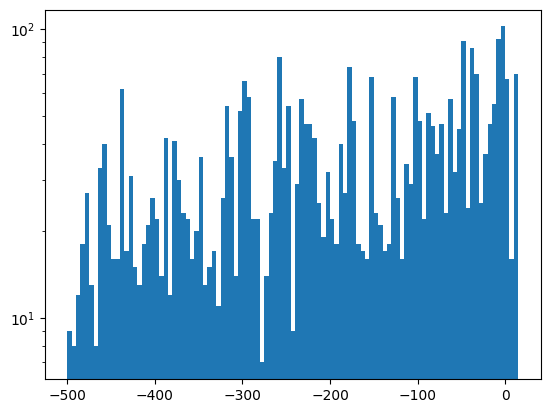

In [116]:
### One-Class SVM 

ocsvm_model = OneClassSVM(nu=.5)
%time ocsvm_model.fit(torfiles.final_features_train[:nb_samples,:nb_pc])
%time dist_ocsvm = ocsvm_model.decision_function(torfiles.final_features_train[:nb_samples,:nb_pc])

_ = plt.hist(dist_ocsvm, bins=np.arange(-500, 20, 5), density=False, log=True)
(dist_ocsvm > 0).mean(), (dist_ocsvm < 0).mean()

CPU times: user 1.92 s, sys: 4.07 ms, total: 1.93 s
Wall time: 1.93 s
CPU times: user 421 ms, sys: 0 ns, total: 421 ms
Wall time: 421 ms


(0.9851851851851852, 0.014814814814814815)

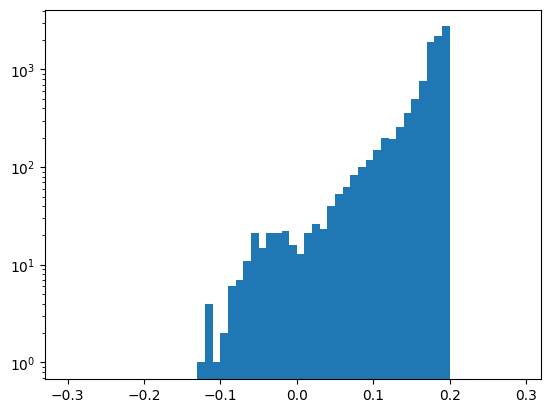

In [117]:
### Isolation Forest

if_model = IsolationForest(n_estimators=2000, max_samples=256, contamination='auto')
%time if_model.fit(torfiles.final_features_train[:nb_samples,:nb_pc])
%time dist_if = if_model.decision_function(torfiles.final_features_train[:nb_samples,:nb_pc])

_ = plt.hist(dist_if, bins=np.arange(-.3, .3, .01), density=False, log=True)
(dist_if > 0).mean(), (dist_if < 0).mean()

CPU times: user 2.2 s, sys: 0 ns, total: 2.2 s
Wall time: 226 ms
CPU times: user 1.96 s, sys: 0 ns, total: 1.96 s
Wall time: 195 ms


(0.6813813813813814, 0.3186186186186186)

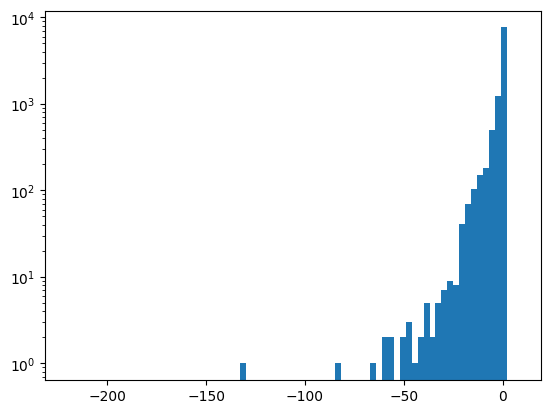

In [118]:
### LocalOutlierFactor

lof_model = LocalOutlierFactor(n_neighbors=20, leaf_size=30, contamination='auto', novelty=True)
%time lof_model.fit(torfiles.final_features_train[:nb_samples,:nb_pc])
%time dist_lof = lof_model.decision_function(torfiles.final_features_train[:nb_samples,:nb_pc])

_ = plt.hist(dist_lof, bins=np.arange(-220, 10, 3), density=False, log=True)
(dist_lof > 0).mean(), (dist_lof < 0).mean()

## 3. Predition on test dataset + save submission

In [76]:
### 1. Extract features from test dataset IN PROGRESS

torfiles_test = TorFiles(file_directory_train='nids-train.pcap', file_directory_test='nids-test.pcap')
torfiles_test.extract_features('final_features_sparse_test.npz', n_components=100, train=False, load=True, torfiles_train=torfiles)

filename = 'nids-test.pcap'
Packet n°     0 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 10000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 20000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 30000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 40000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 50000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 60000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 70000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n° 80000 | Current RAM usage: 0.51 / 24 GB (2.1 %)


Task exception was never retrieved
future: <Task finished name='Task-588912' coro=<TsharkXmlParser.get_packets_from_stream() done, defined at /home/stud09/env/lib/python3.11/site-packages/pyshark/tshark/output_parser/tshark_xml.py:24> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/home/stud09/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_18218/1767787522.py", line 5, in <module>
    torfiles.extract_features('final_features_sparse_test.npz', n_components=100, train=False, load=False)
  File "/tmp/ipykernel_18218/2173859646.py", line 216, in extract_features
    self.read_single_pcap(filename, train=train)
  File "/tmp/ipykernel_18218/2173859646.py", line 131, in read_single_pcap
    for i, packet in enumerate(capture):
  File "/home/stud09/env/lib/python3.11/site-packages/pyshark/capture/capture.py", line 221, in _packets_from_tshark_sync

Packet n° 90000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°100000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°110000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°120000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°130000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°140000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°150000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°160000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°170000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°180000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°190000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°200000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°210000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°220000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°230000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°240000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°250000 | Current RAM usage: 0.51 / 24 GB (2.1 %)
Packet n°26000

OCSVM | Prop inliers: 0.61, prop outliers: 0.39
IF    | Prop inliers: 0.99, prop outliers: 0.01
LOF   | Prop inliers: 0.67, prop outliers: 0.33


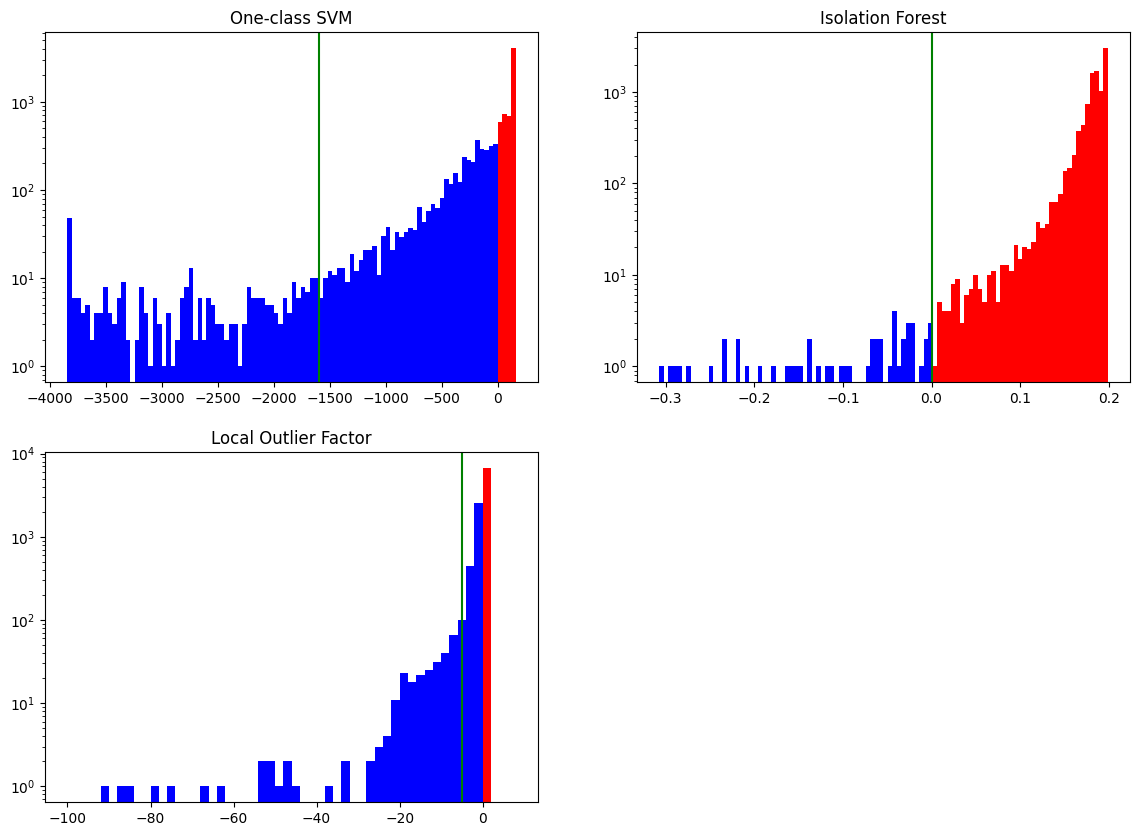

In [162]:
### 2. Get the anomaly scores (not binary prediction)

nb_pc = torfiles_test.final_features_test.shape[1]
nb_samples = torfiles_test.final_features_test.shape[0]
X_test = torfiles_test.final_features_test[:nb_samples,:nb_pc]
log=True
fig = plt.figure(figsize=(14,10))

dist_ocsvm_test = ocsvm_model.decision_function(X_test)
plt.subplot(221)
_, _, patches = plt.hist(dist_ocsvm_test, bins=100, density=False, log=log)
for patch in patches:
    if patch.get_x() < 0:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('red')
plt.title('One-class SVM')
plt.axvline(-1600, c='green')
print(f'OCSVM | Prop inliers: {(dist_ocsvm_test > 0).mean():.2f}, prop outliers: {(dist_ocsvm_test < 0).mean():.2f}')

dist_if_test = if_model.decision_function(X_test)
plt.subplot(222)
_, _, patches = plt.hist(dist_if_test, bins=100, density=False, log=log)
for patch in patches:
    if patch.get_x() < 0:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('red')
plt.title('Isolation Forest')
plt.axvline(0, c='green')
print(f'IF    | Prop inliers: {(dist_if_test > 0).mean():.2f}, prop outliers: {(dist_if_test < 0).mean():.2f}')

dist_lof_test = lof_model.decision_function(X_test)
plt.subplot(223)
_, _, patches = plt.hist(dist_lof_test, bins=np.arange(-100, 10, 2), density=False, log=log)
for patch in patches:
    if patch.get_x() < 0:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('red')
plt.title('Local Outlier Factor')
plt.axvline(-5, c='green')
print(f'LOF   | Prop inliers: {(dist_lof_test > 0).mean():.2f}, prop outliers: {(dist_lof_test < 0).mean():.2f}')


### 3. Compute the number of anomalies with respect to the threshold to define the right one

In [163]:
(dist_ocsvm_test > -1600).mean(), (dist_if_test > 0).mean(), (dist_lof_test > -5).mean()

(0.968784392196098, 0.9949974987493747, 0.9680840420210105)

In [142]:
((dist_ocsvm_test > -1600) * (dist_if_test > .14)).mean(), ((dist_ocsvm_test > -1600) * (dist_lof_test > -5)).mean(), ((dist_if_test > .14) * (dist_lof_test > -5)).mean()

(0.9464732366183092, 0.9451725862931466, 0.9373686843421711)

In [164]:
y_pred = ~(dist_if_test > 0) + 0
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [165]:
torfiles_test.connection_names_test = [packet_name[0]+':'+packet_name[1]+'->192.168.178.30:21' for packet_name in torfiles_test.packet_names_test] # ->192.168.178.30:21;XXX
torfiles_test.connection_names_test

['192.168.178.52:55583->192.168.178.30:21',
 '192.168.178.84:46733->192.168.178.30:21',
 '192.168.178.32:56095->192.168.178.30:21',
 '192.168.178.53:35939->192.168.178.30:21',
 '192.168.178.38:33781->192.168.178.30:21',
 '192.168.178.41:59668->192.168.178.30:21',
 '192.168.178.39:33576->192.168.178.30:21',
 '192.168.178.90:35888->192.168.178.30:21',
 '192.168.178.64:57219->192.168.178.30:21',
 '192.168.178.83:59354->192.168.178.30:21',
 '192.168.178.91:46446->192.168.178.30:21',
 '192.168.178.37:45361->192.168.178.30:21',
 '192.168.178.51:33838->192.168.178.30:21',
 '192.168.178.56:37141->192.168.178.30:21',
 '192.168.178.84:46761->192.168.178.30:21',
 '192.168.178.90:35908->192.168.178.30:21',
 '192.168.178.46:38013->192.168.178.30:21',
 '192.168.178.83:59374->192.168.178.30:21',
 '192.168.178.70:60733->192.168.178.30:21',
 '192.168.178.68:47479->192.168.178.30:21',
 '192.168.178.65:45739->192.168.178.30:21',
 '192.168.178.54:55161->192.168.178.30:21',
 '192.168.178.90:35921->192.168.

In [166]:
### Save submission

submission = []
# Write the prediction as expected output

filenames_test = torfiles_test.connection_names_test
print(len(filenames_test))

for i, filename in enumerate(filenames_test):
    submission += [filename + ';' + str(y_pred[i])]
# Save the output as a text file
print(f'Length of our submission: {len(submission)} | Length of zip file: {len(filenames_test)}')
np.savetxt('output_if_0.csv', np.array(submission), fmt='%s', delimiter=',')

9995
Length of our submission: 9995 | Length of zip file: 9995
